In [1]:
import numpy as np
import torch
#import gradio as gr
from huggingface_hub import from_pretrained_keras
import requests
from PIL import Image
import matplotlib.cm as cm
# import matplotlib.pyplot as plt
import os
import PIL

from torchvision import datasets, transforms

from timm.data import create_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

import models_vit
import utils
import torch.nn.functional as F
import pathlib

In [2]:
classes = ['Alicante', 'Alveralhao', 'Arinto', 'Bastardo', 'Boal',
       'Cabernet Franc', 'Cabernet Sauvignon', 'Carignon Noir', 'Cercial',
       'Chardonnay', 'Codega', 'Codega do Larinho', 'Cornifesto',
       'Donzelinho Branco', 'Donzelinho Tinto', 'Esgana Cao',
       'Fernao Pires', 'Folgasao', 'Gamay', 'Gouveio', 'Malvasia Corada',
       'Malvasia Fina', 'Malvasia Preta', 'Malvasia Rei', 'Merlot',
       'Moscatel Galego', 'Moscatel Galego Roxo', 'Mourisco Tinto',
       'Pinot Blanc', 'Rabigato', 'Rufete', 'Samarrinho',
       'Sauvignon Blanc', 'Sousao', 'Tinta Amarela', 'Tinta Barroca',
       'Tinta Femea', 'Tinta Francisca', 'Tinta Roriz', 'Tinto Cao',
       'Touriga Francesa', 'Touriga Nacional', 'Viosinho']

In [3]:
target_size_dimension = 224
n_classes = len(classes)
model = 'vit_base_patch16'
#weights = '/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/output_only_imagenet/ft/base/checkpoint.pth'
weights = '/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/output_epochs/ft/base/2000/checkpoint.pth'

def get_last_selfattention(model, x):
    x = model.patch_embed(x)
    x = model._pos_embed(x)
    x = model.patch_drop(x)
    x = model.norm_pre(x)
    for i, blk in enumerate(model.blocks):
        if i < len(model.blocks) - 1:
            x = blk(x)
        else:
            x = blk.norm1(x)
            B, N, C = x.shape
            qkv = blk.attn.qkv(x).reshape(B, N, 3, blk.attn.num_heads, blk.attn.head_dim).permute(2, 0, 3, 1, 4)
            q, k, v = qkv.unbind(0)
            q, k = blk.attn.q_norm(q), blk.attn.k_norm(k)

            if blk.attn.fused_attn:
                x = F.scaled_dot_product_attention(
                    q, k, v,
                    dropout_p=blk.attn.attn_drop.p,
                )
            else:
                q = q * blk.attn.scale
                attn = q @ k.transpose(-2, -1)
                attn = attn.softmax(dim=-1)

            return attn

In [4]:
#compose transform
t = []
t.append(
    transforms.Resize((target_size_dimension, target_size_dimension), interpolation=PIL.Image.BICUBIC),  # to maintain same ratio w.r.t. 224 images
)
#t.append(transforms.CenterCrop(target_size_dimension))

t.append(transforms.ToTensor())
t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
t = transforms.Compose(t)

model = models_vit.__dict__[model](
    num_classes=n_classes,
    global_pool=True,
    drop_path_rate = 0.1
)

print(weights)
state = torch.load(weights, map_location='cpu')
print(state.keys())
msg = model.load_state_dict(state['model'], strict=False)
print(msg)
model.to('cpu')
#model.to('cuda')
model.eval()


/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/output_epochs/ft/base/2000/checkpoint.pth
dict_keys(['model', 'optimizer', 'epoch', 'scaler', 'args'])
<All keys matched successfully>


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1-11): 11 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (a

In [5]:

#dataset = '/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/processed/compilado/'
#dataset = '/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/weekly/week2'
#dataset = '/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/aga-test/'
dataset = '/home/gabriel/Downloads/castas-huge2-split/test/'
#ds = datasets.ImageFolder(dataset, transform=t)
ds = datasets.ImageFolder(dataset, transform=t, allow_empty=True)
sampler = torch.utils.data.SequentialSampler(ds)
dl = torch.utils.data.DataLoader(ds, sampler=sampler, batch_size=48, num_workers=1, pin_memory=True)

              precision    recall  f1-score   support

          AC     1.0000    1.0000    1.0000        16
          AV     0.8792    0.9632    0.9193       136
          AT     0.6066    0.7400    0.6667        50
          BT     0.6667    0.7368    0.7000        19
          BA     0.6809    0.9412    0.7901        34
          CF     0.5385    0.7368    0.6222        19
          CS     0.8750    0.7368    0.8000        19
          CN     0.6875    0.5789    0.6286        19
          CC     0.6500    0.8125    0.7222        48
          CD     0.8333    0.7895    0.8108        19
          CG     0.8618    0.7923    0.8256       496
          CR     0.6058    0.8182    0.6961        77
          CT     0.6154    0.8889    0.7273        18
          DB     0.5941    0.7895    0.6780        76
          DT     0.6842    0.6842    0.6842        19
          EC     0.5333    0.5333    0.5333        30
          FP     0.6316    0.7500    0.6857        16
          FG     0.6377    

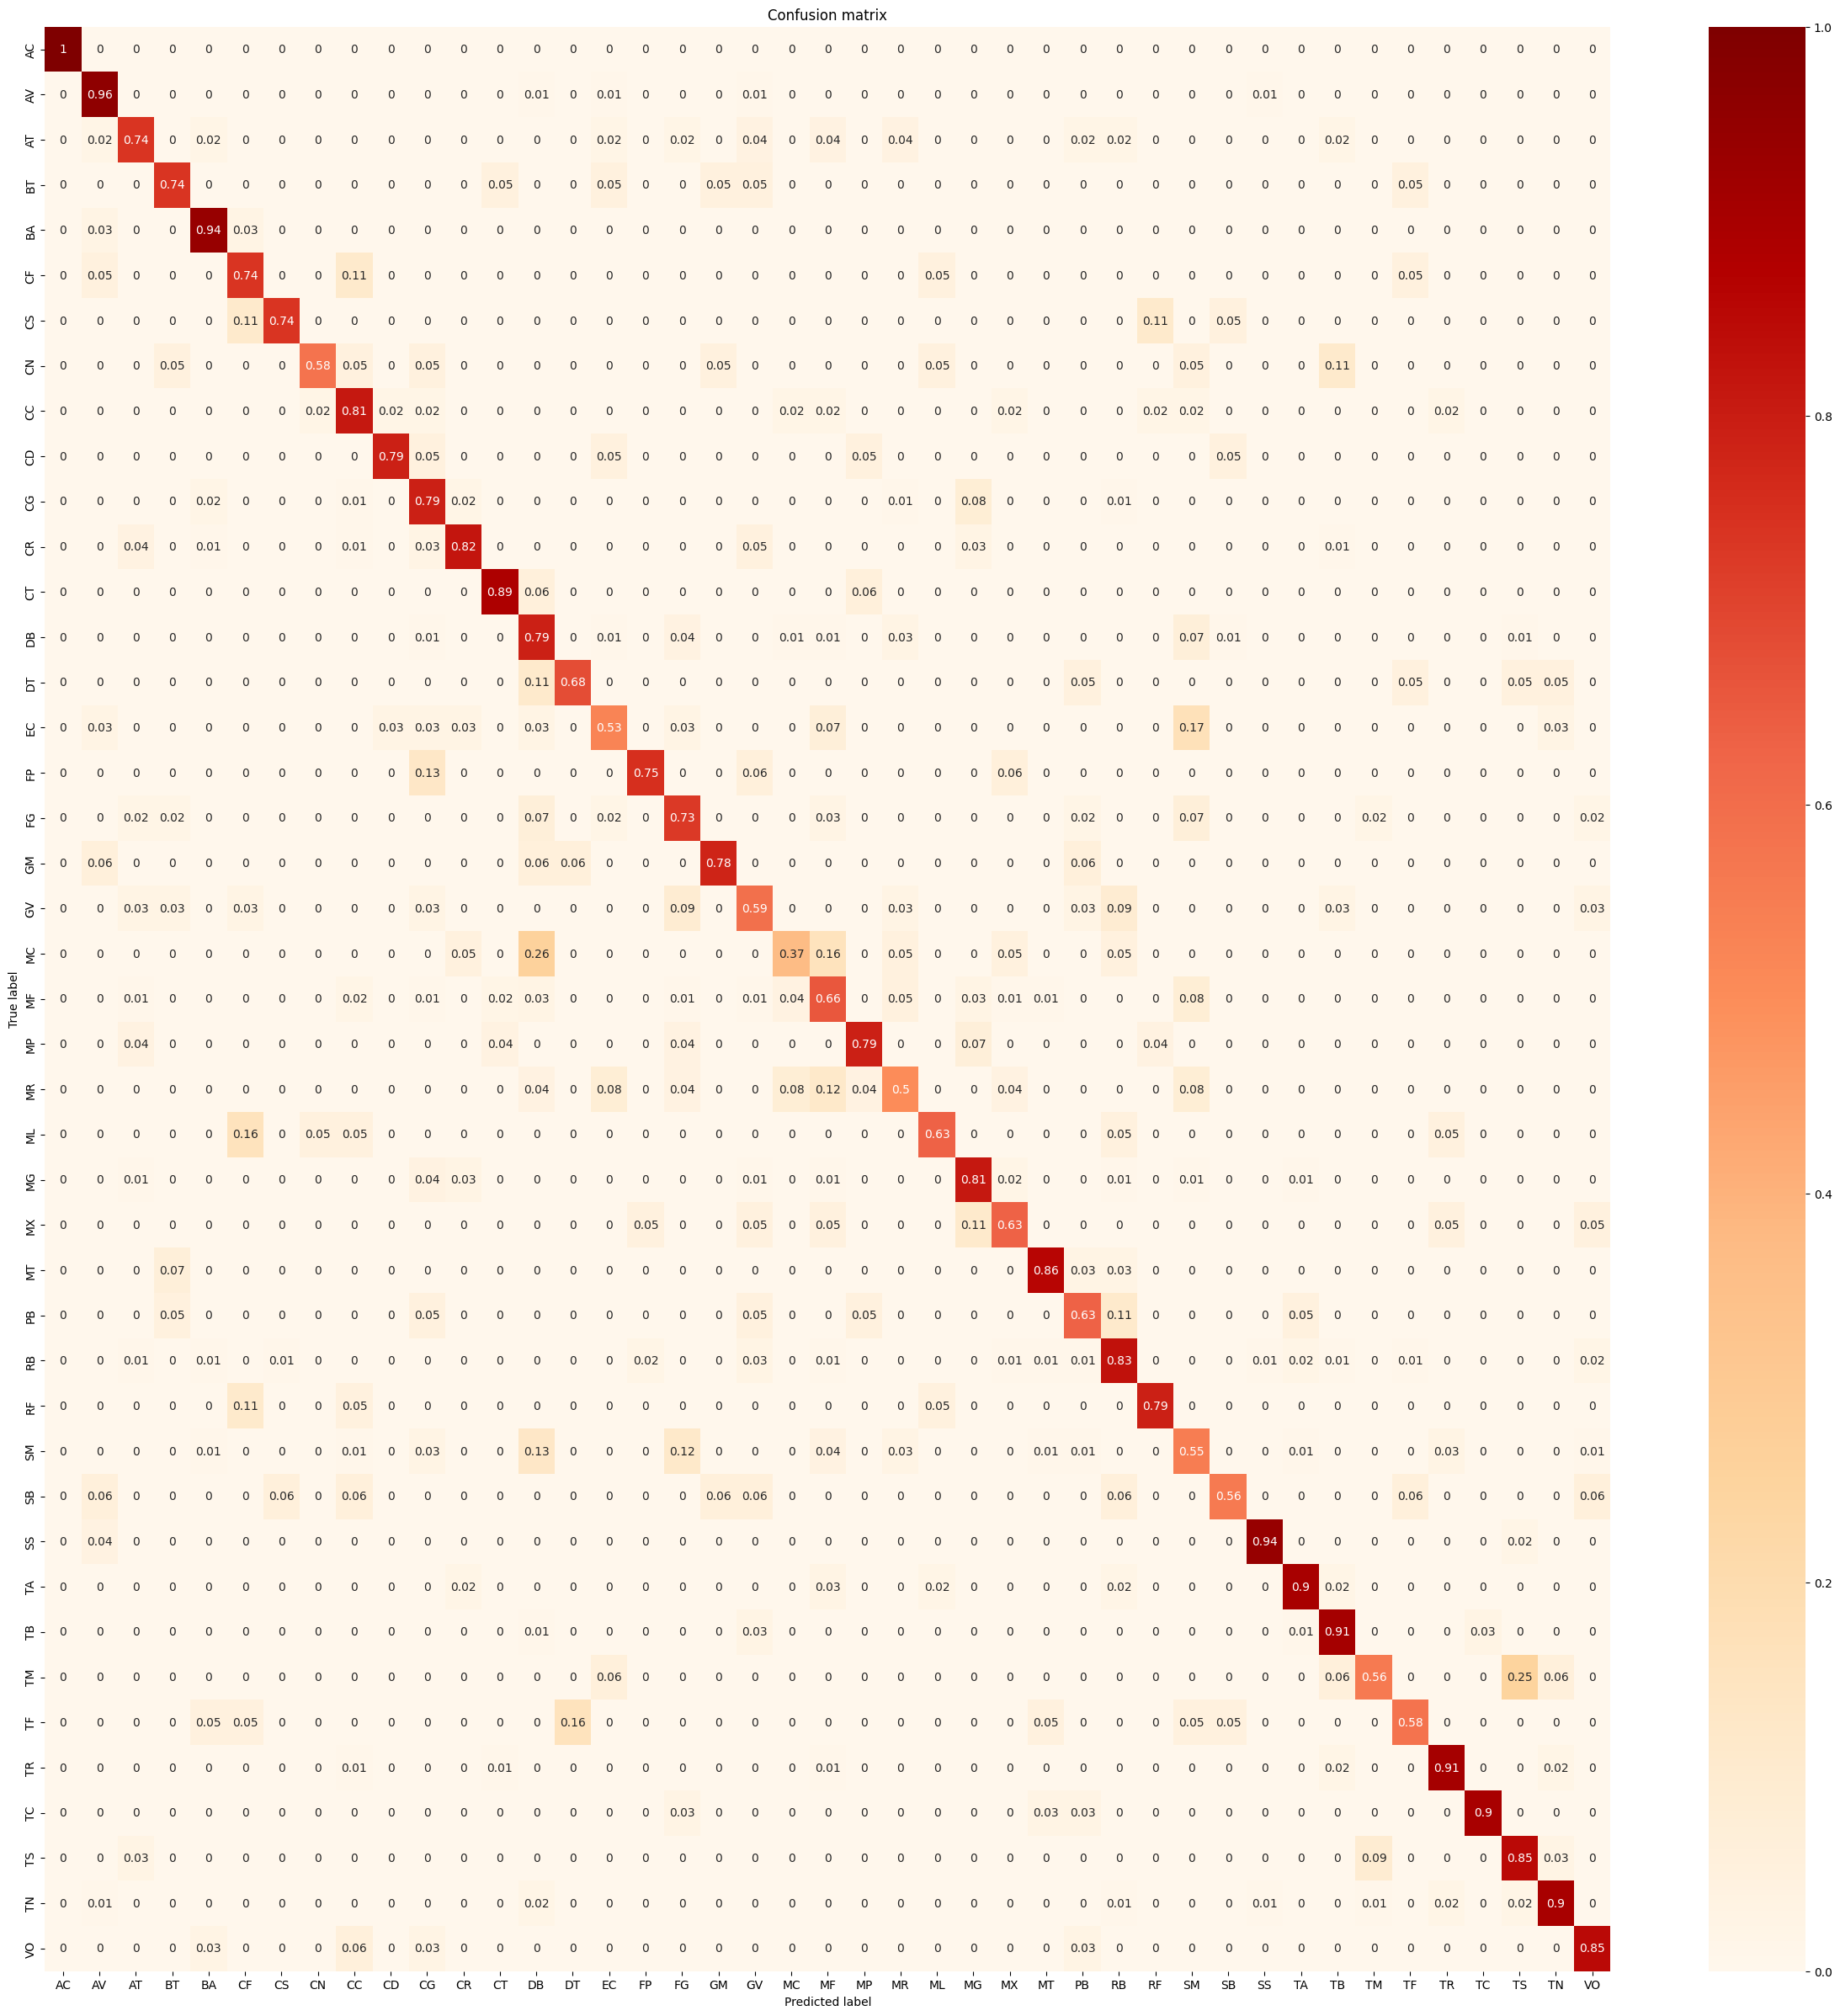

In [6]:
classes_alias = {'tinto cao': 'TC', 'tinta francisca': 'TF', 'alicante': 'AC', 'alveralhao': 'AV', 'arinto': 'AT', 'bastardo': 'BT', 'boal': 'BA', 'cabernet franc': 'CF', 'cabernet sauvignon': 'CS', 'carignon noir': 'CN', 'cercial': 'CC', 'chardonnay': 'CD', 'codega': 'CG', 'codega do larinho': 'CR', 'cornifesto': 'CT', 'donzelinho': 'DZ', 'donzelinho branco': 'DB', 'donzelinho tinto': 'DT', 'esgana cao': 'EC', 'fernao pires': 'FP', 'folgasao': 'FG', 'gamay': 'GM', 'gouveio': 'GV', 'malvasia corada': 'MC', 'malvasia fina': 'MF', 'malvasia preta': 'MP', 'malvasia rei': 'MR', 'merlot': 'ML', 'moscatel galego': 'MG', 'moscatel galego roxo': 'MX', 'mourisco tinto': 'MT', 'pinot blanc': 'PB', 'rabigato': 'RB', 'rufete': 'RF', 'samarrinho': 'SM', 'sauvignon blanc': 'SB', 'sousao': 'SS', 'tinta amarela': 'TA', 'tinta barroca': 'TB', 'tinta femea': 'TM', 'tinta roriz': 'TR', 'touriga francesa': 'TS', 'touriga nacional': 'TN', 'viosinho': 'VO'}
report, result = utils.confusion_matrix(dl, model, class_labels=[classes_alias[c.lower()] for c in classes],mode='pytorch', sns=True, normalize=True, return_images_paths=True)

In [7]:
import json

json.dumps(classes_alias)

'{"tinto cao": "TC", "tinta francisca": "TF", "alicante": "AC", "alveralhao": "AV", "arinto": "AT", "bastardo": "BT", "boal": "BA", "cabernet franc": "CF", "cabernet sauvignon": "CS", "carignon noir": "CN", "cercial": "CC", "chardonnay": "CD", "codega": "CG", "codega do larinho": "CR", "cornifesto": "CT", "donzelinho": "DZ", "donzelinho branco": "DB", "donzelinho tinto": "DT", "esgana cao": "EC", "fernao pires": "FP", "folgasao": "FG", "gamay": "GM", "gouveio": "GV", "malvasia corada": "MC", "malvasia fina": "MF", "malvasia preta": "MP", "malvasia rei": "MR", "merlot": "ML", "moscatel galego": "MG", "moscatel galego roxo": "MX", "mourisco tinto": "MT", "pinot blanc": "PB", "rabigato": "RB", "rufete": "RF", "samarrinho": "SM", "sauvignon blanc": "SB", "sousao": "SS", "tinta amarela": "TA", "tinta barroca": "TB", "tinta femea": "TM", "tinta roriz": "TR", "touriga francesa": "TS", "touriga nacional": "TN", "viosinho": "VO"}'

In [13]:
images = []

import random
import pandas as pd
import shutil
for tc, well_classifier, path in result:
    print(path)
    if well_classifier:
        split = path[0].split(os.sep)
        dic = {}
        dic['class'] = split[-2]
        dic['path'] = path
        try:
            dic['cam'] = split[-1].split(',')[1]
        except:
            dic['cam'] = '0'

        images.append(dic)
        print(f'{tc} -> {well_classifier} -> {path}')

df = pd.DataFrame.from_records(images)


classes = np.unique(df['class'])
save_images = '/home/gabriel/Downloads/selected_castasv6_xai/'
os.makedirs(save_images, exist_ok=True)
images_final = []
for c in classes:
    df_filtred = df[df['class'] == c]
    cam = random.choice(df_filtred['cam'].values)
    df_filtred = df_filtred[df_filtred['cam'] == cam]
    chosen = random.choice(df_filtred['path'].values)
    shutil.copy(chosen, os.path.join(save_images, f'{chosen.split(os.sep)[-1]}'))




    

('/home/gabriel/Downloads/castas-huge2-split/test/Alicante/20230630,BlackBerry_Z10,IMG_20230630_132206.jpg', 0)
0 -> True -> ('/home/gabriel/Downloads/castas-huge2-split/test/Alicante/20230630,BlackBerry_Z10,IMG_20230630_132206.jpg', 0)
('/home/gabriel/Downloads/castas-huge2-split/test/Alicante/20230630,BlackBerry_Z10,IMG_20230630_132228.jpg', 0)
0 -> True -> ('/home/gabriel/Downloads/castas-huge2-split/test/Alicante/20230630,BlackBerry_Z10,IMG_20230630_132228.jpg', 0)
('/home/gabriel/Downloads/castas-huge2-split/test/Alicante/20230630,BlackBerry_Z10,IMG_20230630_132249.jpg', 0)
0 -> True -> ('/home/gabriel/Downloads/castas-huge2-split/test/Alicante/20230630,BlackBerry_Z10,IMG_20230630_132249.jpg', 0)
('/home/gabriel/Downloads/castas-huge2-split/test/Alicante/20230630,Canon_EOS_Rebel_T100,IMG_5829.jpg', 0)
0 -> True -> ('/home/gabriel/Downloads/castas-huge2-split/test/Alicante/20230630,Canon_EOS_Rebel_T100,IMG_5829.jpg', 0)
('/home/gabriel/Downloads/castas-huge2-split/test/Alicante/202

IndexError: list index out of range